# Inference Session API

## Introduction

In this tutorial, you will learn how to infer deployed models in a simple and efficient way with `sly.nn.inference.Session`.
This class is a convenient wrapper for a low-level API. It under the hood is just a communication with the serving app via `requests`.

Let's start with a quick example of how you can connect and make inference of your model!

# Quick overview

*(for detailed tutorial go to the [next section](a-complete-tutorial))*

**Just create the InferenceSession and run inference:**

In [4]:
import os
from dotenv import load_dotenv
import supervisely as sly


# Get your Serving App's task_id from the Supervisely platform
task_id = 27209

# init sly.Api
load_dotenv(os.path.expanduser("~/supervisely.env"))
api = sly.Api()

# Create Inference Session
inference_session = sly.nn.inference.Session(api, task_id=task_id, inference_settings={"conf_thres": 0.55})

# Infer image_id
image_id = 19386161
prediction = inference_session.inference_image_id(image_id)
prediction["annotation"]

{'description': '',
 'size': {'height': 952, 'width': 1200},
 'tags': [],
 'objects': [{'classTitle': 'dog',
   'description': '',
   'tags': [{'name': 'confidence', 'value': 0.89794921875}],
   'points': {'exterior': [[830, 463], [1065, 813]], 'interior': []},
   'geometryType': 'rectangle',
   'shape': 'rectangle'},
  {'classTitle': 'motorcycle',
   'description': '',
   'tags': [{'name': 'confidence', 'value': 0.90087890625}],
   'points': {'exterior': [[0, 261], [571, 845]], 'interior': []},
   'geometryType': 'rectangle',
   'shape': 'rectangle'},
  {'classTitle': 'person',
   'description': '',
   'tags': [{'name': 'confidence', 'value': 0.91796875}],
   'points': {'exterior': [[533, 69], [804, 806]], 'interior': []},
   'geometryType': 'rectangle',
   'shape': 'rectangle'}],
 'customBigData': {}}

## List of all inference methods

### Image inference methods:

In [ ]:
# Infer single image by local path
pred = inference_session.inference_image_path("image_01.jpg")

# Infer batch of images by local paths
pred = inference_session.inference_image_paths(["image_01.jpg", "image_02.jpg"])

# Infer image by ID
pred = inference_session.inference_image_id(17551748)

# Infer batch of images by IDs
pred = inference_session.inference_image_ids([17551748, 17551750])

# Infer image by url
url = "https://images.unsplash.com/photo-1674552791148-c756b0899dba?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=387&q=80"
pred = inference_session.inference_image_url(url)

### Video inference methods:

In [ ]:
from tqdm import tqdm

video_id = 18635803

# Infer video getting each frame as soon as it's ready
for frame_pred in tqdm(inference_session.inference_video_id_async(video_id)):
    print(frame_pred["annotation"]["objects"])

# Infer video without iterator
pred = inference_session.inference_video_id(video_id)

# A Complete Tutorial

## 1. Initialize `sly.nn.inference.Session`

First serve the model you want (e.g. [Serve YOLOv5](https://ecosystem.supervise.ly/apps/yolov5/supervisely/serve)) and copy the `task_id` from the `App sessions` section in the Supervisely platform:

![getting-task-id](https://user-images.githubusercontent.com/31512713/218194505-b161be1e-5a05-488b-8eb7-9bc0f24141e2.png)

**Init your sly.Api:**

*(see [Basics of authentication](https://developer.supervise.ly/getting-started/basics-of-authentication) tutorial)*

In [ ]:
import os
from dotenv import load_dotenv
import supervisely as sly

# init sly.API
load_dotenv(os.path.expanduser("~/supervisely.env"))
api = sly.Api()

**Create an InferenceSession connection to the model:**

In [5]:
# Get your Serving App's task_id from the Supervisely platform
task_id = 27209

# create an inference_session
inference_session = sly.nn.inference.Session(api, task_id=task_id)

**Pass the inference settings** *(Optional, you can set it later or use default)*:

In [6]:
# pass settings by dict
inference_settings = {
    "conf_thres": 0.45
}
inference_session = sly.nn.inference.Session(api, task_id=your_task_id, inference_settings=inference_settings)

**Or pass the inference settings by** `YAML` **file**:

In [7]:
inference_settings_yaml = "settings.yml"
inference_session = sly.nn.inference.Session(api, task_id=your_task_id, inference_settings=inference_settings_yaml)

## 2. Get the model info

### Session info

Each app with a deployed model has its own unique task_id (or session_id which is the same), model_name, pretrained_dataset and other useful info that can be obtained with the `get_session_info()` method.

In [23]:
inference_session.get_session_info()

{'app_name': 'Serve YOLOv5',
 'session_id': 27209,
 'model_files': '/sly-app-data/model/yolov5s.pt',
 'number_of_classes': 80,
 'sliding_window_support': 'advanced',
 'videos_support': True,
 'async_video_inference_support': True,
 'task type': 'object detection',
 'model_name': 'YOLOv5',
 'checkpoint_name': 'yolov5s',
 'pretrained_on_dataset': 'COCO train 2017',
 'device': 'cuda',
 'half': 'True',
 'input_size': 640}

### Project meta of the model

The model may be pretrained on various datasets, like a COCO, ImageNet or even your custom data. The datasets are different in classes/tags they have. Therefore each dataset has its own meta information called `project_meta` in Supervisely. To get the `project_meta` of the dataset the model was pretrained on, use the method `get_model_project_meta()`.

In [27]:
model_meta = inference_session.get_model_project_meta()
print("The first 10 classes of model_meta:")
[cls.name for cls in model_meta.obj_classes][:10]

The first 10 classes of model_meta:


['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light']

The `model_meta` will be used later, when we will visualize model predictions.

### Inference settings

Each model has its own inference settings, like a `conf_thres`, `iou_thres` and others. You can get the full list of supported settings with `get_default_inference_settings()`:

In [29]:
default_settings = inference_session.get_default_inference_settings()
default_settings

{'conf_thres': 0.25,
 'iou_thres': 0.45,
 'augment': False,
 'debug_visualization': False}

### Set the inference settings

You can set these settings with the one of the methods:
- `update_inference_settings(**kwargs)`
- `set_inference_settings(dict_or_yaml)`

**Update only the parameters you want:**

In [31]:
inference_session.update_inference_settings(conf_thres=0.4, iou_thres=0.55)
inference_session.inference_settings

{'conf_thres': 0.4, 'iou_thres': 0.55}

**Set parameters with a dict:**

In [37]:
settings = {
    "conf_thres": 0.25
}
inference_session.set_inference_settings(settings)
inference_session.inference_settings

{'conf_thres': 0.25}

In [8]:
inference_session.set_inference_settings("settings.yml")
inference_session.inference_settings

{'conf_thres': 0.55, 'augment': False}

## 3. Image Inference

**There are several ways how to infer an image:**

- by Supervisely ID
- by local path
- by URL from the web

In [ ]:
# Infer image by local path
pred = inference_session.inference_image_path("image_01.jpg")

# Infer image by ID
pred = inference_session.inference_image_id(image_id=17551748)

# Infer image by url
url = "https://images.unsplash.com/photo-1674552791148-c756b0899dba?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=387&q=80"
pred = inference_session.inference_image_url(url)

**And you can also infer a batch of images:**

In [ ]:
# Infer batch of images by local paths
pred = inference_session.inference_image_paths(["image_01.jpg", "image_02.jpg"])

# Infer batch of images by IDs
pred = inference_session.inference_image_ids([17551748, 17551750])

### Inspecting the model prediction

The prediction is a `dict` with two fields:

- `"annotation"`: contains a predicted annotation, that can be easily converted to `sly.Annotation`.
- `"data"`: additional metadata of the prediction. In most cases you won't need this.

In [9]:
image_id = 19386163
pred = inference_session.inference_image_id(image_id)
pred

{'annotation': {'description': '',
  'size': {'height': 800, 'width': 1200},
  'tags': [],
  'objects': [{'classTitle': 'umbrella',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.85693359375}],
    'points': {'exterior': [[540, 363], [694, 468]], 'interior': []},
    'geometryType': 'rectangle',
    'shape': 'rectangle'},
   {'classTitle': 'car',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.86376953125}],
    'points': {'exterior': [[724, 380], [1198, 708]], 'interior': []},
    'geometryType': 'rectangle',
    'shape': 'rectangle'},
   {'classTitle': 'person',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.8740234375}],
    'points': {'exterior': [[562, 442], [661, 685]], 'interior': []},
    'geometryType': 'rectangle',
    'shape': 'rectangle'},
   {'classTitle': 'car',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.89501953125}],
    'points': {'exterior': [[4, 408], [509, 699]], 'interior

**Converting to the `sly.Annotation` format:**

In [10]:
model_project_meta = inference_session.get_model_project_meta()
predicted_annotation = sly.Annotation.from_json(pred["annotation"], project_meta=model_project_meta)

**Note:** since the prediction contains only class name and coordinates of rectangle for each object, which is not enough to interpret the annotation in Supervisely format correctly, we need to pass the `model_project_meta` too.

### Visualize model prediction

The code below shows how we can visualize the model predictions:

In [26]:
# Download and load the image that was inferred
save_path = "demo_image.jpg"
api.image.download_path(image_id, path=save_path)
image_np = sly.image.read(save_path)

In [38]:
# Convert to sly.Annotation
predicted_annotation = sly.Annotation.from_json(pred["annotation"], model_project_meta)

# Draw the annotation and save it to disk
save_path_predicted = "demo_image_pred.jpg"
predicted_annotation.draw_pretty(bitmap=image_np, output_path=save_path_predicted, fill_rectangles=False, thickness=7)

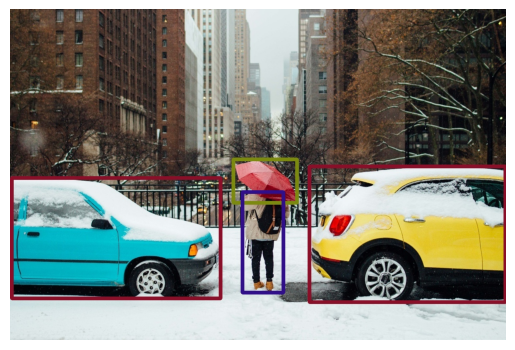

In [39]:
# Show
from matplotlib import pyplot as plt
image_pred = sly.image.read(save_path_predicted)
plt.imshow(image_pred)
plt.axis('off');

### Upload prediction to dataset in Supervisely

**Now you can upload the image with predictions to the Supervisely platform:**

In [66]:
workspace_id = 662

# Create project and dataset
project_info = api.project.create(workspace_id, "My model predictions", change_name_if_conflict=True)
dataset_info = api.dataset.create(project_info.id, "First dataset")

# Update project meta with model's classes
api.project.update_meta(project_info.id, model_project_meta)
project_meta = api.project.get_meta(project_info.id)
project_meta = sly.ProjectMeta.from_json(project_meta)

# Upload the image
img_info = api.image.upload_path(dataset_info.id, name="lemons.jpg", path="lemons.jpg")

# Upload model predictions to Supervisely
# Here we need to update predicted_annotation with a new project_meta obtained from the server:
predicted_annotation = sly.Annotation.from_json(pred['annotation'], project_meta)
api.annotation.upload_ann(img_info.id, predicted_annotation)

**Note:** when you update the `project_meta`, you need to get a newly generated `project_meta` back, because there will be new ids assigned to the classes and tags.

## 4. Video Inference

### Method 1. Inferring video with iterator

**The video inference is simple too.**

The first way is to infer the video with `inference_video_id_async` method. It returns an iterator, which can be useful in processing predictions frame by frame. As soon as the model done with a one frame it will be yielded by the iterator:

In [ ]:
from tqdm import tqdm

video_id = 18635803

for frame_ann in tqdm(inference_session.inference_video_id_async(video_id)):
    print(frame_ann)

There are some parameters can be passed to the video inference:

- `start_frame_index`: the first frame to start
- `frames_count`: total frames to infer
- `frames_direction`: video playback direction, either "forward" or "backward"

#### Getting more information about the inference process:

In [44]:
video_id = 18635803

frame_iterator = inference_session.inference_video_id_async(video_id)
total_frames = len(frame_iterator)
for i, frame_ann in enumerate(frame_iterator):
    labels = sly.Annotation.from_json(frame_ann['annotation'], model_project_meta).labels
    predicted_classes = [x.obj_class.name for x in labels]
    print(f"Frame {i+1}/{total_frames} done. Predicted classes = {predicted_classes}")

{"message": "The video is preparing on the server, this may take a while...", "timestamp": "2023-02-13T16:10:03.827Z", "level": "info"}
{"message": "Inference has started:", "progress": {"current": 0, "total": 10}, "is_inferring": true, "cancel_inference": false, "result": null, "pending_results": [], "timestamp": "2023-02-13T16:10:13.014Z", "level": "info"}


Frame 1/10 done. Predicted classes = ['car']
Frame 2/10 done. Predicted classes = ['car', 'car']
Frame 3/10 done. Predicted classes = ['car', 'car']
Frame 4/10 done. Predicted classes = ['car', 'car']
Frame 5/10 done. Predicted classes = ['car', 'car']
Frame 6/10 done. Predicted classes = ['car', 'car']
Frame 7/10 done. Predicted classes = ['car', 'car']
Frame 8/10 done. Predicted classes = ['car', 'car']
Frame 9/10 done. Predicted classes = ['car']
Frame 10/10 done. Predicted classes = ['car']


#### Stop async video inference with

If you need to stop the inference, use `inference_session.stop_async_inference()`:

In [17]:
from tqdm import tqdm

video_id = 18635803

for i, frame_ann in enumerate(tqdm(inference_session.inference_video_id_async(video_id))):
    if i == 2:
        inference_session.stop_async_inference()

{"message": "The video is preparing on the server, this may take a while...", "timestamp": "2023-02-09T23:15:47.232Z", "level": "info"}
{"message": "Inference has started:", "progress": {"current": 0, "total": 10}, "is_inferring": true, "cancel_inference": false, "result": null, "pending_results": [], "timestamp": "2023-02-09T23:15:55.878Z", "level": "info"}
 30%|███       | 3/10 [00:05<00:13,  1.88s/it]


### Method 2. Inferring video without iterator

If you don't need to iterate every frame, you can use the `inference_video_id` method:

In [ ]:
video_id = 18635803

predictions_list = inference_session.inference_video_id(
    video_id, start_frame_index=5, frames_count=15, frames_direction="forward"
)

**Note:** it is recommended to use this method for very small videos, because the code will wait until the whole video has been inferred and you even can't to track the progress.